A vanilla LSTM for TESLA using low, high, Close, Adj Close and Volume

---



In [83]:
import pandas as pd
import numpy as np
from numpy import log
import io

import yfinance as yf
import requests

import matplotlib.pyplot as plt
from matplotlib import pyplot
import altair as alt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable

### Fetch data from yFinanace

In [84]:
# Download data for a particular stock
# As of now only one stock supported we may generalize the same
stocks = ['TSLA']
stock_data =  yf.download(stocks, '2008-03-01','2023-06-24')

[*********************100%***********************]  1 of 1 completed


In [85]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3269 entries, 2010-06-29 to 2023-06-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3269 non-null   float64
 1   High       3269 non-null   float64
 2   Low        3269 non-null   float64
 3   Close      3269 non-null   float64
 4   Adj Close  3269 non-null   float64
 5   Volume     3269 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.8 KB


In [86]:
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len


2616

In [87]:
X_train = dataset[:int(np.ceil( len(dataset) * .8 ))]
y_test = dataset[int(np.ceil( len(dataset) * .8 )):]
len(X_train), len(y_test)

(2616, 653)

### Apply data normalization using MaxMinScaler

```
# Avoid test info during MaxMin
```



In [88]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#scaled_data_test = scaler.fit_transform(y_test)
#scaled_data_train, scaled_data_test

In [89]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 40 # choose sequence length
x_train, y_train, x_test, y_test = load_data(scaled_data, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2583, 39, 1)
y_train.shape =  (2583, 1)
x_test.shape =  (646, 39, 1)
y_test.shape =  (646, 1)


In [90]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_train.size(),x_train.size()


(torch.Size([2583, 1]), torch.Size([2583, 39, 1]))

In [91]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions

        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train model

In [92]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  10 MSE:  0.004462554585188627
Epoch  20 MSE:  0.003560904646292329
Epoch  30 MSE:  0.0031597083434462547
Epoch  40 MSE:  0.00023845596297178417
Epoch  50 MSE:  0.00035884397220797837
Epoch  60 MSE:  7.707597978878766e-05
Epoch  70 MSE:  5.832470196764916e-05
Epoch  80 MSE:  4.9138670874526724e-05
Epoch  90 MSE:  4.6743709390284494e-05


### Draw loss optimization based on training data

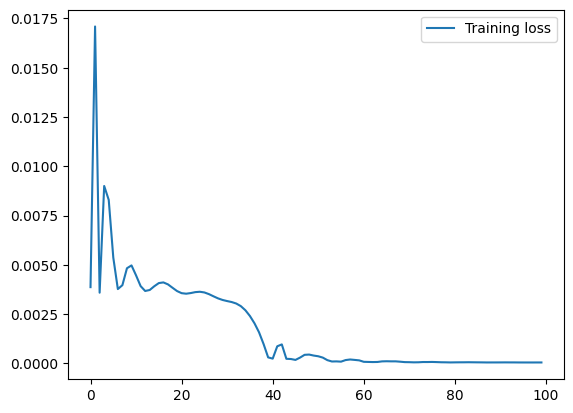

In [93]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

### Model performance statistics

In [94]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print(f"R2 SCORE: {r2_score(y_test[:,0], y_test_pred[:,0])}")

Train Score: 2.72 RMSE
Test Score: 89.88 RMSE
R2 SCORE: -1.2605240418264967


### Visualize the result

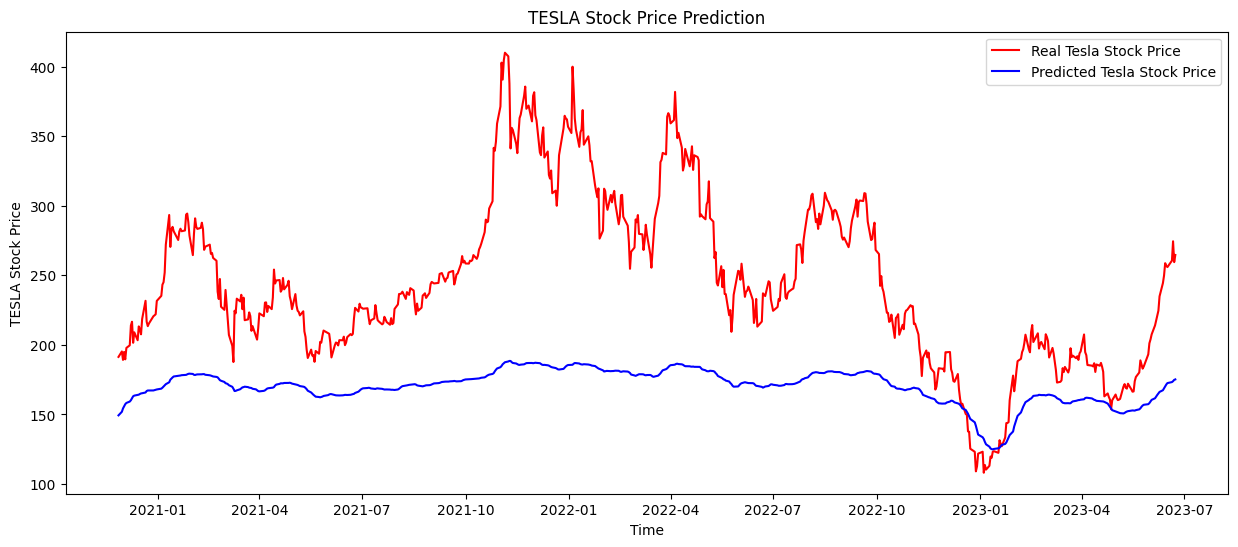

In [95]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[len(data)-len(y_test):].index, y_test, color = 'red', label = 'Real Tesla Stock Price')
axes.plot(data[len(data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Tesla Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.savefig('tesla_pred.png')
plt.show()
